In [1]:
import os
import sys
from itertools import product
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import mlflow
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mlflow
from optuna.trial import create_trial
from optuna.distributions import CategoricalDistribution, IntUniformDistribution, LogUniformDistribution

sys.path.append(os.path.join(os.getcwd(), "../")) 
from results import log_best_model, _get_best_results

In [2]:
# Setting up the tracking_uri and the experiment name
mlflow.set_tracking_uri("../artifacts/mlruns")
mlflow.set_experiment(experiment_name='mapintel-experiment-v1')

In [3]:
# Querying the runs
df_results= mlflow.search_runs()
df_results.shape

Traceback (most recent call last):
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 699, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 529, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '../artifacts/mlruns/1/.trash/meta.yaml' does not exist.


(101, 102)

In [4]:
# Isolate best run
best_run = df_results.loc[df_results['tags.mlflow.runName'] == 'best-model']
df_results = df_results.loc[~(df_results['tags.mlflow.runName'] == 'best-model')]

In [5]:
k_range = [10, 20, 40, 80, 160]
# Compute umap_avgknn_acc_test_mean (if needed)
if 'metrics.umap_avgknn_acc_test_mean' not in df_results.columns:
    df_results['metrics.umap_avgknn_acc_test_mean'] = \
    np.mean([df_results[f'metrics.umap_{k}nn_acc_test_mean'] for k in k_range], axis=0)
    
# Compute umap_avgknn_acc_test_std (if needed)
if 'metrics.umap_avgknn_acc_test_std' not in df_results.columns:
    df_results['metrics.umap_avgknn_acc_test_std'] = \
    np.mean([df_results[f'metrics.umap_{k}nn_acc_test_std'] for k in k_range], axis=0)

# Compute minmax_avg
df_results['metrics.minmax_avg'] = np.mean(MinMaxScaler().fit_transform(df_results[['metrics.nmi_test_mean', 'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean']]), axis=1)

# Compute total_infer_time
df_results['metrics.timer_total_infer_mean'] = np.sum(df_results[['metrics.timer_emb_model_infer_mean', 'metrics.timer_top_model_infer_mean']], axis=1)

In [6]:
# Get highest min-max average result
top_result = df_results.iloc[df_results['metrics.minmax_avg'].argmax()]

# Re-evaluate the model with the best hyperparameters on a train/test split
params = top_result[top_result.index.str.contains('params.')].dropna().sort_index().to_dict()
dtypes = [float, str, int, str, str, int, int, int, int, str]
params = {k.split('.')[1]: t(v) for (k, v), t in zip(params.items(), dtypes)}
distributions = [
    LogUniformDistribution(0.01, 1.0),
    CategoricalDistribution(['eom', 'leaf']),
    CategoricalDistribution([5]),
    CategoricalDistribution(['doc2vec', 'sentence-transformers/msmarco-distilbert-base-v4']),
    CategoricalDistribution(['cosine', 'euclidean']),
    IntUniformDistribution(30, 150),
    IntUniformDistribution(10, 60),
    CategoricalDistribution([2, 5, 10, 25, 50]),
    IntUniformDistribution(10,50),
    CategoricalDistribution(['BERTopic', 'CTM', 'LDA'])
]

# Create trial for best results
best_trial = create_trial(
    value = top_result['metrics.minmax_avg'],
    params = params,
    distributions = dict(zip(params.keys(), distributions))
)

# Get output results for best trial
out = _get_best_results(best_trial)

<ipython-input-6-2989e186cd38>:22: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  best_trial = create_trial(


Load and clean the dataset.
Suggest hyperparameters.
{
  "embedding_model": "sentence-transformers/msmarco-distilbert-base-v4",
  "umap_args__n_neighbors": 14,
  "umap_args__n_components": 10,
  "umap_args__metric": "cosine",
  "topic_model": "BERTopic",
  "min_topic_size": 33,
  "hdbscan_args__min_cluster_size": 110,
  "hdbscan_args__cluster_selection_epsilon": 0.05516517617078291,
  "hdbscan_args__cluster_selection_method": "leaf"
}
Define the embedding model.
Define the topic model.
Fit and transform the SentenceTransformer embedding model.


Batches:   0%|          | 0/454 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Fit and transform the BERTopic topic model.
Reduce embeddings to 2 dimensions with UMAP.


# Training data plots

In [21]:
# Configs
mm = 1/25.4  # milimeters in inches
plt.rcParams.update({'font.family':'Arial'})
outcmap = ListedColormap(
    [(0.9509803921568627, 0.9509803921568627, 0.9509803921568627)]
)

# Data
topic_labels = [".".join(words[:5]) for words in out[-1]["tm_full_output"]["topics"]]
topic_labels[0] = "outliers"
umap_emb = out[-1]["umap_emb_train"]
y = out[2]
y_labels = out[-2]
topics = out[-1]["top_train"]

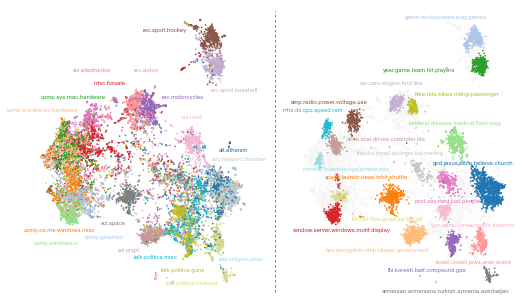

In [22]:
# Define labels and where they should go
labels1 = {
    'alt.atheism': (8.8, 4.5),
    'comp.graphics': (1.7, 1.25),
    'comp.os.ms-windows.misc': (-0.8, 1.5),
    'comp.sys.ibm.pc.hardware': (-1.7, 6),
    'comp.sys.mac.hardware': (0, 6.5),
    'comp.windows.x': (-1, 1),
    'misc.forsale': (2, 7),
    'rec.autos': (4, 7.5),
    'rec.motorcycles': (6, 6.5),
    'rec.sport.baseball': (8.8, 6.75),
    'rec.sport.hockey': (5, 9),
    'sci.crypt': (3, 0.75),
    'sci.electronics': (1, 7.5),
    'sci.med': (6.5, 5.75),
    'sci.space': (2.2, 1.75),
    'soc.religion.christian': (9.1, 4.15),
    'talk.politics.guns': (6, 0),
    'talk.politics.mideast': (6.5, -0.5),
    'talk.politics.misc': (4.5, 0.5),
    'talk.religion.misc': (9.2, 0.4)
}

labels2 = {
    'god.jesus.bible.believe.church': (7.5, 4),
    'game.hockey.team.play.games': (6, 9.5),
    'space.launch.nasa.orbit.shuttle': (1.6, 3.5),
    'key.encryption.chip.clipper.government': (2.2, 0.75),
    'year.game.team.hit.players': (4.5, 7.5),
    'patients.disease.medical.food.msg': (6.5, 5.5),
    'window.server.windows.motif.display': (0.3, 1.5),
    'israel.israeli.jews.arab.arabs': (7.5, 0.3),
    'fbi.koresh.batf.compound.gas': (5, 0),
    'car.cars.engine.ford.like': (3, 7),
    'amp.radio.power.voltage.use': (-0.4, 6.3),
    'drive.scsi.drives.controller.ide': (2.7, 4.9),
    'post.say.dont.just.people': (6.1, 2.6),
    'gun.guns.crime.people.firearms': (7.5, 1.7),
    'armenian.armenians.turkish.armenia.azerbaijan': (6, -0.8),
    'thanks.email.address.list.mailing': (3.5, 4.4),
    'bike.ride.bikes.riding.passenger': (6.6, 6.6),
    'format.files.graphics.file.gif': (2.8, 1.9),
    'mhz.dx.cpu.speed.ram': (-1.3, 6),
    'monitor.monitors.vga.screen.nec': (0.5, 3.8)
}

# Figure 1 - Original labels
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(190*mm, 110*mm))

ax1.scatter(umap_emb[:, 0], umap_emb[:, 1], s=0.5, c=y, cmap="tab20")

# Annotate
for i, (label, coords) in enumerate(labels1.items()):
    ax1.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))
    
# Figure 2 - Topic labels
ax2.scatter(
    umap_emb[topics == -1, 0],
    umap_emb[topics == -1, 1],
    s=0.5,
    c=topics[topics == -1],
    marker=".",
    cmap=outcmap,
)

ax2.scatter(
    umap_emb[topics != -1, 0],
    umap_emb[topics != -1, 1],
    s=0.5,
    c=topics[topics != -1],
    cmap="tab20",
)

# Annotate
for i, (label, coords) in enumerate(labels2.items()):
    ax2.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))

    
# Additional configs
fig1.patch.set_visible(False)
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

plt.plot([0.52, 0.52], [0.05, 0.95], color='black', lw=0.5, linestyle=(0, (5, 5)), transform=plt.gcf().transFigure, clip_on=False)

#plt.show()
plt.savefig("umap_train.pdf", format="pdf", dpi=300)

# Test data plots

In [9]:
# Configs
mm = 1/25.4  # milimeters in inches
plt.rcParams.update({'font.family':'Arial'})
outcmap = ListedColormap(
    [(0.9509803921568627, 0.9509803921568627, 0.9509803921568627)]
)

# Data
topic_labels = [".".join(words[:5]) for words in out[-1]["tm_full_output"]["topics"]]
topic_labels[0] = "outliers"
umap_emb = out[-1]["umap_emb_test"]
y = out[3]
y_labels = out[-2]
topics = out[-1]["top_test"]

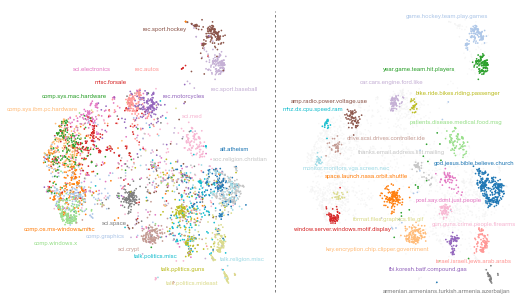

In [10]:
# Define labels and where they should go
labels1 = {
    'alt.atheism': (8.8, 4.5),
    'comp.graphics': (1.7, 1.25),
    'comp.os.ms-windows.misc': (-0.8, 1.5),
    'comp.sys.ibm.pc.hardware': (-1.7, 6),
    'comp.sys.mac.hardware': (0, 6.5),
    'comp.windows.x': (-1, 1),
    'misc.forsale': (2, 7),
    'rec.autos': (4, 7.5),
    'rec.motorcycles': (6, 6.5),
    'rec.sport.baseball': (8.8, 6.75),
    'rec.sport.hockey': (5, 9),
    'sci.crypt': (3, 0.75),
    'sci.electronics': (1, 7.5),
    'sci.med': (6.5, 5.75),
    'sci.space': (2.2, 1.75),
    'soc.religion.christian': (9.1, 4.15),
    'talk.politics.guns': (6, 0),
    'talk.politics.mideast': (6.5, -0.5),
    'talk.politics.misc': (4.5, 0.5),
    'talk.religion.misc': (9.2, 0.4)
}

labels2 = {
    'god.jesus.bible.believe.church': (7.5, 4),
    'game.hockey.team.play.games': (6, 9.5),
    'space.launch.nasa.orbit.shuttle': (1.6, 3.5),
    'key.encryption.chip.clipper.government': (2.2, 0.75),
    'year.game.team.hit.players': (4.5, 7.5),
    'patients.disease.medical.food.msg': (6.5, 5.5),
    'window.server.windows.motif.display': (0.3, 1.5),
    'israel.israeli.jews.arab.arabs': (7.5, 0.3),
    'fbi.koresh.batf.compound.gas': (5, 0),
    'car.cars.engine.ford.like': (3, 7),
    'amp.radio.power.voltage.use': (-0.4, 6.3),
    'drive.scsi.drives.controller.ide': (2.7, 4.9),
    'post.say.dont.just.people': (6.1, 2.6),
    'gun.guns.crime.people.firearms': (7.5, 1.7),
    'armenian.armenians.turkish.armenia.azerbaijan': (6, -0.8),
    'thanks.email.address.list.mailing': (3.5, 4.4),
    'bike.ride.bikes.riding.passenger': (6.6, 6.6),
    'format.files.graphics.file.gif': (2.8, 1.9),
    'mhz.dx.cpu.speed.ram': (-1.3, 6),
    'monitor.monitors.vga.screen.nec': (0.5, 3.8)
}

# Figure 1 - Original labels
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(190*mm, 110*mm))

ax1.scatter(umap_emb[:, 0], umap_emb[:, 1], s=0.5, c=y, cmap="tab20")

# Annotate
for i, (label, coords) in enumerate(labels1.items()):
    ax1.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))
    
# Figure 2 - Topic labels
ax2.scatter(
    umap_emb[topics == -1, 0],
    umap_emb[topics == -1, 1],
    s=0.5,
    c=topics[topics == -1],
    marker=".",
    cmap=outcmap,
)

ax2.scatter(
    umap_emb[topics != -1, 0],
    umap_emb[topics != -1, 1],
    s=0.5,
    c=topics[topics != -1],
    cmap="tab20",
)

# Annotate
for i, (label, coords) in enumerate(labels2.items()):
    ax2.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))

    
# Additional configs
fig1.patch.set_visible(False)
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

plt.plot([0.52, 0.52], [0.05, 0.95], color='black', lw=0.5, linestyle=(0, (5, 5)), transform=plt.gcf().transFigure, clip_on=False)

#plt.show()
plt.savefig("umap_test.pdf", format="pdf", dpi=300)

# Zoom plots

In [11]:
# Configs
mm = 1/25.4  # milimeters in inches
plt.rcParams.update({'font.family': 'Arial'})
outcmap = ListedColormap(
    [(0.9509803921568627, 0.9509803921568627, 0.9509803921568627)]
)

# Data
topic_labels = [".".join(words[:5]) for words in out[-1]["tm_full_output"]["topics"]]
topic_labels[0] = "outliers"
umap_emb = out[-1]["umap_emb_train"]
y = out[2]
y_labels = out[-2]
topics = out[-1]["top_train"]

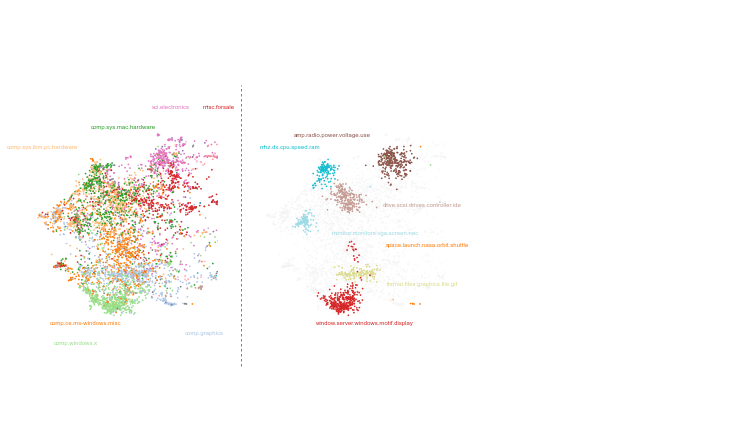

In [12]:
# Define labels and where they should go
labels1 = {
    'alt.atheism': (8.8, 4.5),
    'comp.graphics': (1.7, 1.25),
    'comp.os.ms-windows.misc': (-0.8, 1.5),
    'comp.sys.ibm.pc.hardware': (-1.7, 6),
    'comp.sys.mac.hardware': (0, 6.5),
    'comp.windows.x': (-1, 1),
    'misc.forsale': (2, 7),
    'rec.autos': (4, 7.5),
    'rec.motorcycles': (6, 6.5),
    'rec.sport.baseball': (8.8, 6.75),
    'rec.sport.hockey': (5, 9),
    'sci.crypt': (3, 0.75),
    'sci.electronics': (1, 7),
    'sci.med': (6.5, 5.75),
    'sci.space': (2.2, 1.75),
    'soc.religion.christian': (9.1, 4.15),
    'talk.politics.guns': (6, 0),
    'talk.politics.mideast': (6.5, -0.5),
    'talk.politics.misc': (4.5, 0.5),
    'talk.religion.misc': (9.2, 0.4)
}

labels2 = {
    'god.jesus.bible.believe.church': (7.5, 4),
    'game.hockey.team.play.games': (6, 9.5),
    'space.launch.nasa.orbit.shuttle': (1.6, 3.5),
    'key.encryption.chip.clipper.government': (2.2, 0.75),
    'year.game.team.hit.players': (4.5, 7.5),
    'patients.disease.medical.food.msg': (6.5, 5.5),
    'window.server.windows.motif.display': (0.3, 1.5),
    'israel.israeli.jews.arab.arabs': (7.5, 0.3),
    'fbi.koresh.batf.compound.gas': (5, 0),
    'car.cars.engine.ford.like': (3, 7),
    'amp.radio.power.voltage.use': (-0.4, 6.3),
    'drive.scsi.drives.controller.ide': (1.5, 4.5),
    'post.say.dont.just.people': (6.1, 2.6),
    'gun.guns.crime.people.firearms': (7.5, 1.7),
    'armenian.armenians.turkish.armenia.azerbaijan': (6, -0.8),
    'thanks.email.address.list.mailing': (3.5, 4.4),
    'bike.ride.bikes.riding.passenger': (6.6, 6.6),
    'format.files.graphics.file.gif': (1.5, 2.5),
    'mhz.dx.cpu.speed.ram': (-1.3, 6),
    'monitor.monitors.vga.screen.nec': (0.5, 3.8)
}

# Zoom in limits
x1, x2 = -2, 2
y1, y2 =  1, 7

# Figure 1 - Original labels
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(190*mm, 110*mm))

ax1.scatter(umap_emb[:, 0], umap_emb[:, 1], s=0.5, c=y, cmap="tab20")

# Annotate
for i, (label, coords) in enumerate(labels1.items()):
    ax1.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))

# Zoom in
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)
    
# Figure 2 - Topic labels
ax2.scatter(
    umap_emb[topics == -1, 0],
    umap_emb[topics == -1, 1],
    s=0.5,
    c=topics[topics == -1],
    marker=".",
    cmap=outcmap,
)

ax2.scatter(
    umap_emb[topics != -1, 0],
    umap_emb[topics != -1, 1],
    s=0.5,
    c=topics[topics != -1],
    cmap="tab20",
)

# Annotate
for i, (label, coords) in enumerate(labels2.items()):
    ax2.annotate(label, 
                 coords,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=6, color=plt.cm.tab20(i))

# Zoom in
ax2.set_xlim(x1, x2)
ax2.set_ylim(y1, y2)

    
# Additional configs
fig1.patch.set_visible(False)
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()

plt.plot([0.52, 0.52], [0.05, 0.95], color='black', lw=0.5, linestyle=(0, (5, 5)), transform=plt.gcf().transFigure, clip_on=False)

#plt.show()
plt.savefig("umap_train_zoom.pdf", format="pdf", dpi=300)